# Statistics Explained articles: lemmas and matching with Eurostat's Concepts and Definitions Database 

### Loading Spacy's large model


In [1]:
import re
import pandas as pd
import spacy
import sys
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline

## Run to install the language library, then comment-out
#!{sys.executable} -m spacy download en_core_web_lg

nlp = spacy.load('en_core_web_lg') 
nlp.max_length = 1500000

print('Finished loading.')



Finished loading.


In [2]:
from datetime import datetime

def file_name(pre,ext):
    current_time = datetime.now() 
    return pre + '_'+ str(current_time.month)+ '_' + str(current_time.day) + \
                 '_' + str(current_time.hour)+ '_' + str(current_time.minute)  +'.'+ext

In [3]:
import pyodbc
c = pyodbc.connect('DSN=Virtuoso All;DBA=ESTAT;UID=kimon;PWD=RkhvQYZ442e2JVXLHdtW')
cursor = c.cursor()

In [4]:
import re
## import unicodedata as ud

def clean(x, quotes=True):
    if pd.isnull(x): return x  
    x = x.strip()
    
    ## make letter-question mark-letter -> letter-quote-space-letter !!! but NOT in the lists of URLs!!!
    if quotes:
        x = re.sub(r'([A-Za-z])\?([A-Za-z])','\\1\' \\2',x) 
    
    ## make letter-question mark-space lower case letter letter-quote-space letter
    x = re.sub(r'([A-Za-z])\? ([a-z])','\\1\' \\2',x) 

    ## delete ,000 commas in numbers    
    x = re.sub(r'\b(\d+),(\d+)\b','\\1\\2',x) ## CORRECTED
    
    ## delete  000 spaces in numbers
    x = re.sub(r'\b(\d+) (\d+)\b','\\1\\2',x) ## CORRECTED
    
    ## remove more than one spaces
    x = re.sub(r' +', ' ',x)
    
    ## remove start and end spaces
    x = re.sub(r'^ +| +$', '',x,flags=re.MULTILINE) 
    
    ## space-comma -> comma
    x = re.sub(r' \,',',',x)
    
    ## space-dot -> dot
    x = re.sub(r' \.','.',x)
    
    x = re.sub(r'â.{2}',"'",x) ### !!! NEW: single quotes are read as: âXX
    
    #x = x.encode('latin1').decode('utf-8') ## â\x80\x99
    #x = ud.normalize('NFKD',x).encode('ascii', 'ignore').decode()
    
    return x

### Statistics explained articles

* IDs and titles from dat_link_info, with resource_information_id=1, i.e. Eurostat (see ESTAT.V1.mod_resource_information) and matching IDs from dat_article.
* Carry out data cleansing on titles

In [5]:
SQLCommand = """SELECT id, title 
                FROM ESTAT.V1.dat_link_info 
                WHERE resource_information_id=1 AND id IN (SELECT id FROM ESTAT.V1.dat_article) """

SE_df = pd.read_sql(SQLCommand,c)

SE_df['title'] = SE_df['title'].apply(clean)

SE_df.head(5)

,id,title
0,7,Accidents at work statistics
1,13,National accounts and GDP
2,16,Railway safety statistics in the EU
3,17,Railway freight transport statistics
4,18,Railway passenger transport statistics - quart...


### Add paragraphs titles and contents

* From dat_article_paragraph with abstract=0 (i.e. "no").
* Match article_id from dat_article_paragraph with id from dat_article.
* Carry out data cleansing on titles and paragraph contents.

In [6]:
SQLCommand = """SELECT article_id, title, content 
                FROM ESTAT.V1.dat_article_paragraph
                WHERE abstract=0 AND article_id IN (SELECT id FROM ESTAT.V1.dat_article) """

add_content = pd.read_sql(SQLCommand,c)
add_content['title'] = add_content['title'].apply(clean)
add_content['content'] = add_content['content'].apply(clean)
add_content

,article_id,title,content
0,2905,Absences from work sharply increase in first h...,Absences from work recorded unprecedented high...
1,2905,Absences: 9.5 % of employment in Q4 2019 and 1...,The article's next figure (Figure 4) compares ...
2,2905,Higher share of absences from work among women...,"Considering all four quarters of 2020, the sha..."
3,2905,Absences from work due to own illness or disab...,"From Q4 2019 to Q4 2020, the number of people ..."
4,2905,Absences from work due to holidays,"Expressed as a share of employed people, absen..."
...,...,...,...
3854,10539,General presentation and definition,Scope of asylum statistics and Dublin statisti...
3855,10539,Methodological aspects in asylum statistics,Annual aggregate of the number of asylum appli...
3856,10539,Methodological aspects in Dublin statistics,Asymmetries For most of the collected Dublin s...
3857,10539,What questions can or cannot be answered with ...,How many asylum seekers are entering EU Member...


### Aggregate above paragraph titles and contents  from SE articles paragraphs by article id

* Create a column _raw content_ which gathers all paragraph titles and contents in one text per article.

In [7]:
add_content_grouped = add_content.groupby(['article_id'])[['title','content']].aggregate(lambda x: list(x))
add_content_grouped.reset_index(drop=False, inplace=True)
for i in range(len(add_content_grouped)):
    add_content_grouped.loc[i,'raw content'] = ''
    for (a,b) in zip(add_content_grouped.loc[i,'title'],add_content_grouped.loc[i,'content']):
        add_content_grouped.loc[i,'raw content'] += ' '+a + ' ' + b
add_content_grouped = add_content_grouped[['article_id','raw content']]    

add_content_grouped

,article_id,raw content
0,7,"Number of accidents In 2018, there were 3.1 m..."
1,13,Developments for GDP in the EU-27: growth sin...
2,16,Fall in the number of railway accidents 9 % f...
3,17,Downturn for EU transport performance in 2019...
4,18,Rail passenger transport performance continue...
...,...,...
860,10456,Problem After successfully identifying and jo...
861,10470,"Problem In France, there was significant room..."
862,10506,General overview Nine PEEIs concern short-ter...
863,10531,What are administrative sources? The term 'ad...


### Merge raw content of SE articles with main file

* Also, add title to raw content

In [8]:
SE_df = pd.merge(SE_df,add_content_grouped,left_on='id',right_on='article_id',how='inner')
del(add_content, add_content_grouped)


SE_df.drop(['article_id'],axis=1,inplace=True)

SE_df['raw content'] = SE_df['title'] +'. '+SE_df['raw content']
SE_df

SE_df.head(5)

,id,title,raw content
0,7,Accidents at work statistics,Accidents at work statistics. Number of accid...
1,13,National accounts and GDP,National accounts and GDP. Developments for G...
2,16,Railway safety statistics in the EU,Railway safety statistics in the EU. Fall in ...
3,17,Railway freight transport statistics,Railway freight transport statistics. Downtur...
4,18,Railway passenger transport statistics - quart...,Railway passenger transport statistics - quart...


### Check for missing information

In [9]:
import numpy as np

SE_df = SE_df.replace('', np.nan) 
print(SE_df.isnull().sum())

#outfile = file_name('SE_df','xlsx')
#SE_df.to_excel(outfile)

id             0
title          0
raw content    0
dtype: int64


### Collecting information on tokens, stems and lemmas


In [10]:
docs = list(nlp.pipe(SE_df['raw content']))

import nltk
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer(language='english')


def extract_tokens_plus_meta(ix,doc:spacy.tokens.doc.Doc):
    res = list()
    for sent in doc.sents:
        for tok in sent:
            
            if tok.is_stop or tok.is_digit or tok.is_punct:
                continue
                
            ## no alphabetic characters - drop
            if not re.match(r'[a-zA-Z]', tok.lemma_):
                continue

            ## too short, one letter only - drop   
            if len(tok.lemma_) < 2:
               continue
            
            ## contains a dot - drop
            #if re.search(r'\.', tok.lemma_):
            #    continue     

            ## contains a digit - drop
            #if re.search(r'\d', tok.lemma_):
            #    continue                     
                
            ## starts with a non-alphanumeric character - drop              
            if re.search(r'^\W', tok.lemma_):
                continue   
                
            ## contains a _: drop - NEW
            if re.search(r'_', tok.lemma_):
                continue                     

            ## contains a *: drop - NEW
            if re.search(r'\*', tok.lemma_):
                continue                     
                
            ## starts with \EQ: drop - NEW    
            if re.search(r'^\\EQ', tok.lemma_):
                continue                     

            ## one letter only and digits or dots: drop - NEW
            if re.search(r'^[a-zA-Z][\d\.]+$', tok.lemma_):
                continue                     
                
            ## + not at the end: drop - NEW
            if re.search(r'\+(?!$)', tok.lemma_):
                continue                     

            ## contains a = : drop - NEW
            if re.search(r'=', tok.lemma_):
                continue                     
                
                
            res.append((ix,tok.text, tok.lemma_.upper(), stemmer.stem(tok.text)))
    
    return(res)    
    

d=[]
for ix, doc in enumerate(docs):
    if (ix+1) % 100==0: print(ix+1,' out of ',len(docs))
    meta = extract_tokens_plus_meta(ix,doc)
    d.extend(meta)

cols = ["doc_id", "token", "lemma","stem"]
lemmas_df = pd.DataFrame(d,columns=cols)    

del(d)

lemmas_df

100  out of  865
200  out of  865
300  out of  865
400  out of  865
500  out of  865
600  out of  865
700  out of  865
800  out of  865


,doc_id,token,lemma,stem
0,0,Accidents,ACCIDENT,accid
1,0,work,WORK,work
2,0,statistics,STATISTIC,statist
3,0,Number,NUMBER,number
4,0,accidents,ACCIDENT,accid
...,...,...,...,...
829036,864,fingerprint,FINGERPRINT,fingerprint
829037,864,database,DATABASE,databas
829038,864,record,RECORD,record
829039,864,asylum,ASYLUM,asylum


### A rule to reduce some duplicates: if the stem is the same, select the most common lemma


In [11]:

## find most common lemma in each group of same stems
grp =lemmas_df.groupby(['stem'])[['lemma']].aggregate(lambda x:x.value_counts().index[0]) 
print(grp)

lemmas_df = pd.merge(lemmas_df,grp,on='stem')
lemmas_df

lemmas_df.rename(columns={'lemma_y':'lemma'},inplace=True)
lemmas_df.drop(columns=['stem','lemma_x'],inplace=True)
del(grp)

lemmas_df

             lemma
stem              
a.in          A.IN
a.m.          A.M.
a1f            A1F
aachen      AACHEN
aagr          AAGR
...            ...
zpiz          ZPIZ
zrsz          ZRSZ
zuid          ZUID
zã¡padnã  ZÃ¡PADNÃ
zã¼rich    ZÃ¼RICH

[9775 rows x 1 columns]


,doc_id,token,lemma
0,0,Accidents,ACCIDENT
1,0,accidents,ACCIDENT
2,0,accidents,ACCIDENT
3,0,accidents,ACCIDENT
4,0,accidents,ACCIDENT
...,...,...,...
829036,864,EASO,EASO
829037,864,AMIF,AMIF
829038,864,AMIF,AMIF
829039,864,COM/2019/126,COM/2019/126


* Group by doc_id and lemma to calculate the number of occurences of each lemma in each document (column 'freq_in_doc').
* Again group by doc_id and lemma to gather token occurences into dictionaries per document and lemma.
* Merge above to collect information together.


In [12]:

## Group by doc_id and lemma to calculate the number of occurences of each lemma in each document (column 'freq_in_doc').
lemmas_df1 = lemmas_df.groupby(['doc_id','lemma']).size().reset_index(name='freq_in_doc')

## Again group by doc_id and lemma to gather token occurences into dictionaries per document and lemma.
lemmas_df2 = lemmas_df.groupby(['doc_id','lemma'])[['token']].aggregate(lambda x: dict(Counter(x)))

## Merge above to collect information together.
lemmas_df3 = pd.merge(lemmas_df1,lemmas_df2,on=['doc_id','lemma'],how='inner')

del(lemmas_df, lemmas_df1, lemmas_df2)
    
lemmas_df3

,doc_id,lemma,freq_in_doc,token
0,0,ABSENCE,1,{'absence': 1}
1,0,ABSOLUTE,2,{'absolute': 2}
2,0,ACCIDENT,74,"{'Accidents': 2, 'accidents': 62, 'accident': 10}"
3,0,ACCORD,2,{'according': 2}
4,0,ACCOUNT,4,"{'account': 1, 'accounted': 3}"
...,...,...,...,...
217258,864,WORK,7,"{'work': 3, 'working': 1, 'worked': 2, 'works'..."
217259,864,WORLD,1,{'world': 1}
217260,864,YEAR,26,"{'year': 20, 'years': 5, 'yearly': 1}"
217261,864,YORK,1,{'York': 1}


* Group by lemma only to calculate the number of documents where each lemma appears (appear_all_docs) and from this calculate the IDF.
* Merge with main file.
* Group by doc_id only to calculate the number of lemmas per document (lemmas_in_doc). From this and the stored frequencies of lemmas in documents calculate the TF.
* Merge with main file.
* Calculate the TF-IDF per lemma and document.
* Calculate also overall frequencies, freq_overall = sum of freq_in_doc over all documents.
* Check TF-IDF statistics.


        doc_id       lemma  freq_in_doc                               token  \
0            0     ABSENCE            1                      {'absence': 1}   
1           12     ABSENCE            1                      {'absence': 1}   
2           42     ABSENCE            1                      {'absence': 1}   
3           56     ABSENCE            1                      {'absence': 1}   
4           78     ABSENCE            2                      {'absence': 2}   
...        ...         ...          ...                                 ...   
217258     864       HAGUE            1                        {'Hague': 1}   
217259     864          IM            1                           {'IM': 1}   
217260     864  ORDINARILY            4  {'ordinarily': 3, 'Ordinarily': 1}   
217261     864      REVOKE            1                       {'revoke': 1}   
217262     864       WAIVE            1                       {'waived': 1}   

        appear_all_docs       IDF  
0              

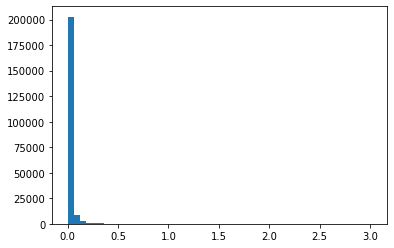

count    217263.000000
mean          0.022865
std           0.056879
min           0.000174
25%           0.005525
50%           0.009915
75%           0.019454
max           3.020863
Name: TF_IDF, dtype: float64
0.009914812129354553
0.01945378950760235


,doc_id,lemma,freq_in_doc,token,appear_all_docs,TF_IDF,freq_overall
0,0,ABSENCE,1,{'absence': 1},49,0.010038,190
1,12,ABSENCE,1,{'absence': 1},49,0.010798,190
2,42,ABSENCE,1,{'absence': 1},49,0.007832,190
3,56,ABSENCE,1,{'absence': 1},49,0.008993,190
4,78,ABSENCE,2,{'absence': 2},49,0.005601,190
...,...,...,...,...,...,...,...
217258,857,INTAMEL,1,{'INTAMEL': 1},1,0.042445,1
217259,857,MASSAGE,1,{'massage': 1},1,0.042445,1
217260,857,PARLOUR,1,{'parlours': 1},1,0.042445,1
217261,857,SCENE,3,"{'scenes': 1, 'scene': 2}",1,0.127334,3


In [13]:

## Group by lemma only to calculate the number of documents where each lemma appears and from this calculate the IDF.
tmp = lemmas_df3.groupby(['lemma']).aggregate({'doc_id':'count'})
tmp.rename(columns={'doc_id':'appear_all_docs'},inplace=True)
tmp['IDF'] = np.log((max(lemmas_df3['doc_id'])+1)/(tmp['appear_all_docs']+1))

## Merge with main file.
lemmas_df4 = pd.merge(lemmas_df3,tmp,on='lemma')
print(lemmas_df4)

## Group by doc_id only to calculate the number of lemmas per document. 
tmp2=lemmas_df3.groupby(['doc_id']).aggregate({'lemma':'count'})
tmp2.rename(columns={'lemma':'lemmas_in_doc'},inplace=True)
print(tmp2)

## From this and the stored frequencies of lemmas in documents calculate the TF.
lemmas_df5 = pd.merge(lemmas_df4,tmp2,on='doc_id')
lemmas_df5['TF'] = lemmas_df5['freq_in_doc']/lemmas_df5['lemmas_in_doc']

## Calculate the TF-IDF per lemma and document.
lemmas_df5['TF_IDF'] = lemmas_df5['TF']*lemmas_df5['IDF']
print(lemmas_df5)


## overall frequencies
tmp3 = lemmas_df5.groupby(['lemma']).aggregate({'freq_in_doc':'sum'}) ## overall frequency
tmp3.rename(columns={'freq_in_doc':'freq_overall'},inplace=True)
lemmas_df5 = pd.merge(lemmas_df5,tmp3,on='lemma')


del(tmp,tmp2,lemmas_df3,lemmas_df4)

## Check TF-IDF statistics.
plt.hist(lemmas_df5['TF_IDF'],bins=50)
plt.show()
print(lemmas_df5['TF_IDF'].describe())
print(np.median(lemmas_df5['TF_IDF']))
print(np.percentile(lemmas_df5['TF_IDF'], 75))

lemmas_df5.drop(columns=['IDF','lemmas_in_doc','TF'],inplace=True)
lemmas_df5


* Merge with the file with the SE articles titles.


In [14]:
lemmas_df6=pd.merge(SE_df[['id','title']],lemmas_df5,left_index=True,right_on='doc_id')
#lemmas_df6 = lemmas_df6[lemmas_df6['TF_IDF'] >= np.percentile(lemmas_df6['TF_IDF'], 97)]

lemmas_df6.sort_values(by=['doc_id','lemma'],inplace=True,ignore_index=True)
lemmas_df6.drop(columns=['doc_id'],inplace=True)
lemmas_df6

,id,title,lemma,freq_in_doc,token,appear_all_docs,TF_IDF,freq_overall
0,7,Accidents at work statistics,ABSENCE,1,{'absence': 1},49,0.010038,190
1,7,Accidents at work statistics,ABSOLUTE,2,{'absolute': 2},165,0.011625,341
2,7,Accidents at work statistics,ACCIDENT,74,"{'Accidents': 2, 'accidents': 62, 'accident': 10}",38,0.807530,708
3,7,Accidents at work statistics,ACCORD,2,{'according': 2},318,0.007025,708
4,7,Accidents at work statistics,ACCOUNT,4,"{'account': 1, 'accounted': 3}",549,0.006378,3922
...,...,...,...,...,...,...,...,...
217258,10539,Asylum statistics introduced,WORK,7,"{'work': 3, 'working': 1, 'worked': 2, 'works'...",401,0.008381,3640
217259,10539,Asylum statistics introduced,WORLD,1,{'world': 1},195,0.002320,750
217260,10539,Asylum statistics introduced,YEAR,26,"{'year': 20, 'years': 5, 'yearly': 1}",670,0.010317,6531
217261,10539,Asylum statistics introduced,YORK,1,{'York': 1},2,0.008850,2


* Any documents lost?

In [15]:
set(SE_df['id']) - set(lemmas_df6['id'])

len(set(SE_df['id']) - set(lemmas_df6['id']))

0

### Eurostat's Concepts and Definitions Database 

In [16]:
SQLCommand = """SELECT id, code_id, term
                FROM ESTAT.V1.dat_estat_glossary 
             """


concepts_df = pd.read_sql(SQLCommand,c)
concepts_df

concepts_df['term'] = concepts_df['term'].apply(lambda x: re.sub(r'[()]','',x))
concepts_df['term'] = concepts_df['term'].apply(lambda x: re.sub(r'Â','A',x))
concepts_df



,id,code_id,term
0,1,12789,"n,k rule"
1,2,12799,"p,q rule"
2,3,19247,Aµ-ARGUS
3,4,5545,Abandoned wine-growing area
4,5,20003,Abduction by a legal guardian
...,...,...,...
11215,11216,4277,Value adjustments on investments
11216,11217,4284,Value of transactions between affiliated enter...
11217,11218,4285,Value re-adjustments on investments
11218,11219,19099,Widened agricultural census


* lemmatize concepts and definitions
* losing some very few terms from the rules below

In [17]:
docs_concepts = list(nlp.pipe(concepts_df['term']))


def extract_tokens_plus_meta_concepts(doc:spacy.tokens.doc.Doc):
    tokens=[]
    lemmas = []
    stems=[]
    for tok in doc:

        #if tok.is_stop or tok.is_digit or tok.is_punct:
        if tok.is_digit or tok.is_punct:
            continue
                
        if not re.match(r'[a-zA-Z]', tok.lemma_):
            continue

        ## too short, one letter only - drop   
        if len(tok.lemma_) < 2:
            continue
            
        ## contains a dot - drop
        #if re.search(r'\.', tok.lemma_):
        #    continue     

        ## contains a digit - drop
        #if re.search(r'\d', tok.lemma_):
        #    continue                     

        ## starts with a non-alphanumeric character - drop              
        if re.search(r'^\W', tok.lemma_):
            continue   
                
        ## contains a _: drop - NEW
        if re.search(r'_', tok.lemma_):
            continue                     

        ## contains a *: drop - NEW
        if re.search(r'\*', tok.lemma_):
            continue                     
                
        ## starts with \EQ: drop - NEW    
        if re.search(r'^\\EQ', tok.lemma_):
            continue                     

        ## one letter only and digits or dots: drop - NEW
        if re.search(r'^[a-zA-Z][\d\.]+$', tok.lemma_):
            continue                     
                
        ## + not at the end: drop - NEW
        if re.search(r'\+(?!$)', tok.lemma_):
            continue                     

        ## contains a = : drop - NEW
        if re.search(r'=', tok.lemma_):
            continue                     
            
            
        
        tokens.append(tok.text)
        lemmas.append(tok.lemma_.upper())
        stems.append(stemmer.stem(tok.text))
    
    return((tokens,stems,lemmas))    
    

d=[]
for ix, doc in enumerate(docs_concepts):
    if (ix+1) % 100==0: print(ix+1,' out of ',len(docs_concepts))
    code=concepts_df.loc[ix,'code_id']
    term = concepts_df.loc[ix,'term']
    #print(ix,code,term)
    tokens,stems,lemmas= extract_tokens_plus_meta_concepts(doc)
    if len(tokens) == 0 and len(stems) == 0 and len(lemmas) ==0: ## losing M1,M2,M3
        print(ix,doc)
    else:    
        d.append((code,term,tokens,stems,lemmas))

concepts_df2 = pd.DataFrame(d,columns=['code_id','term','tokens','stems','lemmas'])    
del(d,concepts_df)
concepts_df2


100  out of  11220
200  out of  11220
300  out of  11220
400  out of  11220
500  out of  11220
600  out of  11220
700  out of  11220
800  out of  11220
900  out of  11220
1000  out of  11220
1100  out of  11220
1200  out of  11220
1300  out of  11220
1400  out of  11220
1500  out of  11220
1600  out of  11220
1700  out of  11220
1800  out of  11220
1900  out of  11220
2000  out of  11220
2100  out of  11220
2200  out of  11220
2300  out of  11220
2400  out of  11220
2500  out of  11220
2600  out of  11220
2700  out of  11220
2800  out of  11220
2900  out of  11220
3000  out of  11220
3100  out of  11220
3200  out of  11220
3300  out of  11220
3400  out of  11220
3500  out of  11220
3600  out of  11220
3700  out of  11220
3800  out of  11220
3900  out of  11220
4000  out of  11220
4100  out of  11220
4200  out of  11220
4300  out of  11220
4400  out of  11220
4500  out of  11220
4600  out of  11220
4700  out of  11220
4800  out of  11220
4900  out of  11220
5000  out of  11220
5100  out

,code_id,term,tokens,stems,lemmas
0,12789,"n,k rule",[rule],[rule],[RULE]
1,12799,"p,q rule",[rule],[rule],[RULE]
2,19247,Aµ-ARGUS,[Aµ-ARGUS],[aµ-argus],[AΜ-ARGU]
3,5545,Abandoned wine-growing area,"[Abandoned, wine, growing, area]","[abandon, wine, grow, area]","[ABANDON, WINE, GROW, AREA]"
4,20003,Abduction by a legal guardian,"[Abduction, by, legal, guardian]","[abduct, by, legal, guardian]","[ABDUCTION, BY, LEGAL, GUARDIAN]"
...,...,...,...,...,...
11212,4277,Value adjustments on investments,"[Value, adjustments, on, investments]","[valu, adjust, on, invest]","[VALUE, ADJUSTMENT, ON, INVESTMENT]"
11213,4284,Value of transactions between affiliated enter...,"[Value, of, transactions, between, affiliated,...","[valu, of, transact, between, affili, enterpris]","[VALUE, OF, TRANSACTION, BETWEEN, AFFILIATED, ..."
11214,4285,Value re-adjustments on investments,"[Value, re, adjustments, on, investments]","[valu, re, adjust, on, invest]","[VALUE, RE, ADJUSTMENT, ON, INVESTMENT]"
11215,19099,Widened agricultural census,"[Widened, agricultural, census]","[widen, agricultur, census]","[WIDEN, AGRICULTURAL, CENSUS]"


In [18]:
concepts_df2['tokens']= concepts_df2['tokens'].apply(lambda x: ' '.join(t for t in x))
concepts_df2['stems']= concepts_df2['stems'].apply(lambda x: ' '.join(t for t in x))
concepts_df2['lemmas']= concepts_df2['lemmas'].apply(lambda x: ' '.join(t for t in x))
concepts_df2

,code_id,term,tokens,stems,lemmas
0,12789,"n,k rule",rule,rule,RULE
1,12799,"p,q rule",rule,rule,RULE
2,19247,Aµ-ARGUS,Aµ-ARGUS,aµ-argus,AΜ-ARGU
3,5545,Abandoned wine-growing area,Abandoned wine growing area,abandon wine grow area,ABANDON WINE GROW AREA
4,20003,Abduction by a legal guardian,Abduction by legal guardian,abduct by legal guardian,ABDUCTION BY LEGAL GUARDIAN
...,...,...,...,...,...
11212,4277,Value adjustments on investments,Value adjustments on investments,valu adjust on invest,VALUE ADJUSTMENT ON INVESTMENT
11213,4284,Value of transactions between affiliated enter...,Value of transactions between affiliated enter...,valu of transact between affili enterpris,VALUE OF TRANSACTION BETWEEN AFFILIATED ENTERP...
11214,4285,Value re-adjustments on investments,Value re adjustments on investments,valu re adjust on invest,VALUE RE ADJUSTMENT ON INVESTMENT
11215,19099,Widened agricultural census,Widened agricultural census,widen agricultur census,WIDEN AGRICULTURAL CENSUS


* apply rule to reduce duplicates: same stems -> same lemmas

In [19]:
grp =concepts_df2.groupby(['stems'])[['lemmas']].aggregate(lambda x:x.value_counts().index[0]) 
print(grp)


                                                           lemmas
stems                                                            
abandon wine grow area                     ABANDON WINE GROW AREA
abduct by anoth famili member  ABDUCTION BY ANOTHER FAMILY MEMBER
abduct by legal guardian              ABDUCTION BY LEGAL GUARDIAN
abduct of minor                                ABDUCTION OF MINOR
abiot servic                                      ABIOTIC SERVICE
...                                                           ...
year to date growth rate                 YEAR TO DATE GROWTH RATE
yield                                                       YIELD
yield curv                                            YIELD CURVE
zero coupon bond                                 ZERO COUPON BOND
zero tillag                                          ZERO TILLAGE

[9362 rows x 1 columns]


In [20]:

concepts_df2 = pd.merge(concepts_df2,grp,on='stems')
del(grp)
#print(concepts_df2)
concepts_df2.rename(columns={'lemmas_y':'lemmas'},inplace=True)
concepts_df2.drop(columns=['lemmas_x'],inplace=True)
concepts_df2.drop(columns=['stems'],inplace=True)
concepts_df2

,code_id,term,tokens,lemmas
0,12789,"n,k rule",rule,RULE
1,12799,"p,q rule",rule,RULE
2,19218,Rule,Rule,RULE
3,19247,Aµ-ARGUS,Aµ-ARGUS,AΜ-ARGU
4,5545,Abandoned wine-growing area,Abandoned wine growing area,ABANDON WINE GROW AREA
...,...,...,...,...
11212,4277,Value adjustments on investments,Value adjustments on investments,VALUE ADJUSTMENT ON INVESTMENT
11213,4284,Value of transactions between affiliated enter...,Value of transactions between affiliated enter...,VALUE OF TRANSACTION BETWEEN AFFILIATED ENTERP...
11214,4285,Value re-adjustments on investments,Value re adjustments on investments,VALUE RE ADJUSTMENT ON INVESTMENT
11215,19099,Widened agricultural census,Widened agricultural census,WIDEN AGRICULTURAL CENSUS


### Search unique lemmas from articles in lemmatized concepts and definitions

In [21]:
res = lemmas_df6.groupby(['lemma']).size().to_frame('size').reset_index() ## unique lemmas in SE_df
res['Contained_in']=[[] for i in range(len(res))]
#print(res)
search_in = concepts_df2['lemmas'].apply(lambda x: x.split(' '))
#print(search_in)
for i in range(len(res)):
    term = res.loc[i,'lemma']
    if (i+1) % 1000==0:
        print(i+1,' of ',len(res),' unique lemmas: ',term)
    #print([(concepts_df2.loc[j,'term'],x) for (j,x) in enumerate(search_in) if term in x])
    for (j,x) in enumerate(search_in):
        if term in x:
            res.loc[i,'Contained_in'].append((concepts_df2.loc[j,'code_id'], concepts_df2.loc[j,'term'],x))
            

1000  of  9536  unique lemmas:  BROAD
2000  of  9536  unique lemmas:  DCD
3000  of  9536  unique lemmas:  EXTRAPOLATION
4000  of  9536  unique lemmas:  IACS
5000  of  9536  unique lemmas:  LUMP
6000  of  9536  unique lemmas:  OUTBALANCE
7000  of  9536  unique lemmas:  RECOGNISE
8000  of  9536  unique lemmas:  SRB30
9000  of  9536  unique lemmas:  UNSPECIFIED


In [22]:
res


,lemma,size,Contained_in
0,A.IN,1,[]
1,A.M.,3,[]
2,A1F,2,[]
3,AACHEN,1,[]
4,AAGR,5,"[(17347, Average annual growth rate AAGR, [AVE..."
...,...,...,...
9531,ZPIZ,1,[]
9532,ZRSZ,1,[]
9533,ZUID,3,[]
9534,ZÃ¡PADNÃ,2,[]


* merge with main file from articles

In [1]:


lemmas_df7=pd.merge(lemmas_df6,res,on=['lemma'])
lemmas_df7.drop(columns=['size'],inplace=True)
del(lemmas_df6)

outfile = file_name('SE_vs_Eurostat_Glossary_lemmas','xlsx')
lemmas_df7.to_excel(outfile)

NameError: name 'pd' is not defined

In [24]:
lemmas_df7

,id,title,lemma,freq_in_doc,token,appear_all_docs,TF_IDF,freq_overall,Contained_in
0,7,Accidents at work statistics,ABSENCE,1,{'absence': 1},49,0.010038,190,"[(2163, Long-term absence from work, [LONG, TE..."
1,72,Adult learning statistics - characteristics of...,ABSENCE,1,{'absence': 1},49,0.010798,190,"[(2163, Long-term absence from work, [LONG, TE..."
2,246,The EU in the world - population,ABSENCE,1,{'absence': 1},49,0.007832,190,"[(2163, Long-term absence from work, [LONG, TE..."
3,418,Government finance statistics - quarterly data,ABSENCE,1,{'absence': 1},49,0.008993,190,"[(2163, Long-term absence from work, [LONG, TE..."
4,554,the introduction,ABSENCE,2,{'absence': 2},49,0.005601,190,"[(2163, Long-term absence from work, [LONG, TE..."
...,...,...,...,...,...,...,...,...,...
217258,10539,Asylum statistics introduced,HAGUE,1,{'Hague': 1},1,0.009484,1,[]
217259,10539,Asylum statistics introduced,IM,1,{'IM': 1},1,0.009484,1,"[(18672, SDMX Information Model, SDMX-IM, [SDM..."
217260,10539,Asylum statistics introduced,ORDINARILY,4,"{'ordinarily': 3, 'Ordinarily': 1}",1,0.037935,4,[]
217261,10539,Asylum statistics introduced,REVOKE,1,{'revoke': 1},1,0.009484,1,[]
